### LightGBM
- XGBoost보다 학습에 걸리는 시간과 메모리 사용량이 적고, 기능적으로 다양함
- XGBoost와 예측 성능이 크게 다르지 않음.
- 단점 : 적은 데이터 세트에 적용할 경우 과적합 발생 가능성이 있음.
- lightgbm 패키지 내에서 파이썬 래퍼용과 사이킷런 래퍼 모듈을 모두 가짐
- LGBMClassifier / LGBMRegres
- 일반 GBM 계열의 트리 분할과 다르게 리프 중심 트리 분할 방식을 사용.
- 기존에는 균형 트리 분할 (Level wise)를 사용해 과적합에 더 강한 구조를 가질 수 있었지만 균형을 맞추기 위한 시간이 필요함
- 이와 달리 LightGBM은 트리의 균형을 맞추지 않고 최대 손실 값을 가지는 리프 노드를 지속 분할하며 비대칭적인 규칙트리를 생성함.

#### LightGBM 하이퍼 파라미터
- num_iterations [defalt = 100]
- learning_rate [default = 0.1] : 0에서 1 사이 값을 지정, 부스팅 스텝을 반복 수행할 때 업데이트되는 학습률
- max_depth [default = -1]: 0보다 작은 값을 지정하면 깊이에 제한이 없음 
- min_data_in_leaf [default = 20] : 결정 트리의 min_samples_leaf와 동일
- num_leave [default = 31] : 하나의 트리가 가질 수 있는 최대 리프 개수
- boosting : 부스팅의 트리를 생성하는 알고리즘 기술
  - gbdt : 일반적인 그래디언트 부스팅 결정 트리
  - rf : 랜덤 포레스트
- bagging_fraction : 과적합을 제어하기 위한 데이터 샘플링 비율
- feature_fraction : 학습 때마다 무작위로 선택하는 피처의 비율
- lambda_l2 : L2 regulation 제어를 위한 값
- lambda_l1 : L1 regulation 제어를 위한 값
- **Learning task 파라미터**
  - objective : 최솟값을 가져야 할 손실함수를 정의하는데 이는 xgboost의 objective 파라미터와 동일. 회귀, 다중 클래스 분류, 이진 분류에 따라 objective인 손실 함수 지정

#### 하이퍼 파라미터 튜닝 방안
num_leaves 개수를 중심으로 min_child_samples, max_depth를 함께 조정하며 모델의 복잡도를 줄이는 방향으로 튜닝을 함.
- learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 기본적인 튜닝 방안이고 이를 적용하는 것도 좋지만 과적합을으로 인한 성능 저하의 위험도 유념해야 함.

#### LightGBM 적용 - 위스콘신 유방암 예측
lightgbm 패키지의 LGBMClassifier를 임포트해 사용, XGBoost와 마찬가지로 early stopping이 가능함. fit()에 조기 중단 파라미터를 적용

#### 분류 실습 - 캐글 산탄데르 고객 만족 예측
- XGBoost와 LightGBM을 활용해 고객 만족 여부 예측
- 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부 예측
- Target==1: 불만 가진 고객, Target == 0 : 만족한 고객
- 모델의 성능평가 : ROC-AUC(ROC 곡선 영역)으로 평가

In [50]:
!pip install lightgbm==2.2.1
# 오류가 나서 구글링 해보니, 버전을 다운그레이드하라고 해서 버전 다운그레이드하였습니다

   ---------------------------------------- 0.0/492.9 kB ? eta -:--:--
    --------------------------------------- 10.2/492.9 kB ? eta -:--:--
    --------------------------------------- 10.2/492.9 kB ? eta -:--:--
   ---- ---------------------------------- 61.4/492.9 kB 465.5 kB/s eta 0:00:01
   ------------------- -------------------- 245.8/492.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------  491.5/492.9 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 492.9/492.9 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.2
    Uninstalling lightgbm-3.3.2:
      Successfully uninstalled lightgbm-3.3.2


In [53]:
# lightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target


# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400)

# lightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, eval_metric = 'logloss', eval_set = evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 280, number of negative: 175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[32  5]
 [ 2 75]]
정확도 : 0.9386, 정밀도 : 0.9375, 재현율 : 0.9740,     F1 : 0.9554, AUC:0.9926


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

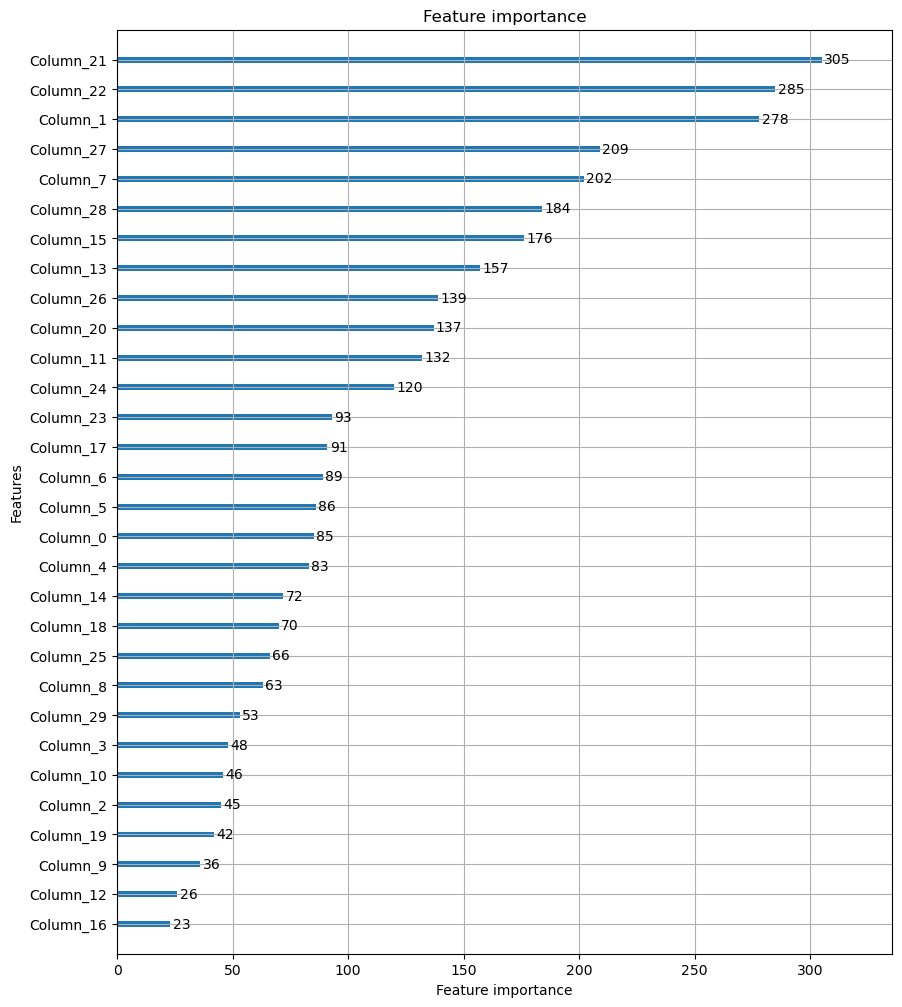

In [16]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(lgbm_wrapper, ax=ax)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('C:/Users/gyw78/Desktop/ewha/3-1/esaa/과제/train_santander.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [25]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [27]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

# 대부분이 만족이며 불만족 고객은 4%에 불과

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [28]:
cust_df.describe()
# 각 피처의 값 문포 알아보기

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [29]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)
# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DF의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                   test_size = 0.2, random_state = 0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape : {0}, 테스트 세트 shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape : (60816, 369), 테스트 세트 shape: (15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


학습과 테스트 데이터 세트 모두 TARGET의 값 분포가 원본 데이터와 유사하게 전체 데이터 4%

#### XGBOOST모델 학습과 하이퍼 파라미터 튜닝
- XGBoost의 학습 모델 생성 후 ROC AUC로 예측 결과 평가

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators, random=state =156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, 
           eval_metrics = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average = 'macro')
print('roc auc : {0:.4f}'.format(xgb_roc_score))

In [36]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators = 100)

params = {'max_depth' : [5, 7], 'min_child_weight' : [1,3], 'colsample_bytree' : [0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv =3)
gridcv.fit(X_train, y_train, eval_metric= 'auc', early_stopping_rounds=30,
          eval_set = [(X_train, y_train), (X_test, y_test)])
print('gridsearchcv 최적 파라미터:', gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

# 이전 예제의 roc-auc가 0.8419에서 하이퍼 파라미터를 튜닝한 후 0.8448로 약간 개선됨. 
# 캐글과 같은 경연에서는 도움이 될 수 있음

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79161	validation_1-auc:0.79321
[1]	validation_0-auc:0.81865	validation_1-auc:0.81375
[2]	validation_0-auc:0.82586	validation_1-auc:0.81846
[3]	validation_0-auc:0.82789	validation_1-auc:0.82226
[4]	validation_0-auc:0.83249	validation_1-auc:0.82677
[5]	validation_0-auc:0.83477	validation_1-auc:0.83225
[6]	validation_0-auc:0.83340	validation_1-auc:0.82654
[7]	validation_0-auc:0.84223	validation_1-auc:0.83487
[8]	validation_0-auc:0.84586	validation_1-auc:0.83682
[9]	validation_0-auc:0.84557	validation_1-auc:0.83472
[10]	validation_0-auc:0.84423	validation_1-auc:0.83181
[11]	validation_0-auc:0.84428	validation_1-auc:0.82920
[12]	validation_0-auc:0.85176	validation_1-auc:0.83433
[13]	validation_0-auc:0.85540	validation_1-auc:0.83565
[14]	validation_0-auc:0.85719	validation_1-auc:0.83696
[15]	validation_0-auc:0.85849	validation_1-auc:0.83561
[16]	validation_0-auc:0.85964	validation_1-auc:0.83578
[17]	validation_0-auc:0.86092	validation_1-auc:0.83570
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80013	validation_1-auc:0.79686
[1]	validation_0-auc:0.82084	validation_1-auc:0.81574
[2]	validation_0-auc:0.82744	validation_1-auc:0.82189
[3]	validation_0-auc:0.83029	validation_1-auc:0.82317
[4]	validation_0-auc:0.83578	validation_1-auc:0.82564
[5]	validation_0-auc:0.83777	validation_1-auc:0.83385
[6]	validation_0-auc:0.83741	validation_1-auc:0.83162
[7]	validation_0-auc:0.84373	validation_1-auc:0.83436
[8]	validation_0-auc:0.84836	validation_1-auc:0.83664
[9]	validation_0-auc:0.84790	validation_1-auc:0.83583
[10]	validation_0-auc:0.84717	validation_1-auc:0.83268
[11]	validation_0-auc:0.84654	validation_1-auc:0.83066
[12]	validation_0-auc:0.85378	validation_1-auc:0.83578
[13]	validation_0-auc:0.85799	validation_1-auc:0.83859
[14]	validation_0-auc:0.85962	validation_1-auc:0.83984
[15]	validation_0-auc:0.86143	validation_1-auc:0.84003
[16]	validation_0-auc:0.86269	validation_1-auc:0.84049
[17]	validation_0-auc:0.86401	validation_1-auc:0.84009
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80039	validation_1-auc:0.80013
[1]	validation_0-auc:0.82111	validation_1-auc:0.82026
[2]	validation_0-auc:0.82749	validation_1-auc:0.82627
[3]	validation_0-auc:0.83124	validation_1-auc:0.82830
[4]	validation_0-auc:0.83475	validation_1-auc:0.82881
[5]	validation_0-auc:0.83677	validation_1-auc:0.83385
[6]	validation_0-auc:0.83648	validation_1-auc:0.83085
[7]	validation_0-auc:0.84336	validation_1-auc:0.83472
[8]	validation_0-auc:0.84624	validation_1-auc:0.83404
[9]	validation_0-auc:0.84541	validation_1-auc:0.83287
[10]	validation_0-auc:0.84555	validation_1-auc:0.83039
[11]	validation_0-auc:0.84525	validation_1-auc:0.82995
[12]	validation_0-auc:0.85144	validation_1-auc:0.83489
[13]	validation_0-auc:0.85525	validation_1-auc:0.83803
[14]	validation_0-auc:0.85746	validation_1-auc:0.84145
[15]	validation_0-auc:0.85818	validation_1-auc:0.84082
[16]	validation_0-auc:0.86005	validation_1-auc:0.84075
[17]	validation_0-auc:0.86126	validation_1-auc:0.84139
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79210	validation_1-auc:0.79292
[1]	validation_0-auc:0.81759	validation_1-auc:0.81404
[2]	validation_0-auc:0.82567	validation_1-auc:0.81864
[3]	validation_0-auc:0.82819	validation_1-auc:0.82244
[4]	validation_0-auc:0.83233	validation_1-auc:0.82618
[5]	validation_0-auc:0.83480	validation_1-auc:0.83163
[6]	validation_0-auc:0.83342	validation_1-auc:0.82840
[7]	validation_0-auc:0.84265	validation_1-auc:0.83512
[8]	validation_0-auc:0.84614	validation_1-auc:0.83742
[9]	validation_0-auc:0.84573	validation_1-auc:0.83475
[10]	validation_0-auc:0.84426	validation_1-auc:0.83066
[11]	validation_0-auc:0.84358	validation_1-auc:0.82936
[12]	validation_0-auc:0.85089	validation_1-auc:0.83491
[13]	validation_0-auc:0.85457	validation_1-auc:0.83785
[14]	validation_0-auc:0.85644	validation_1-auc:0.83894
[15]	validation_0-auc:0.85744	validation_1-auc:0.83784
[16]	validation_0-auc:0.85870	validation_1-auc:0.83899
[17]	validation_0-auc:0.86002	validation_1-auc:0.83854
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79931	validation_1-auc:0.79594
[1]	validation_0-auc:0.81987	validation_1-auc:0.81503
[2]	validation_0-auc:0.82734	validation_1-auc:0.82126
[3]	validation_0-auc:0.83110	validation_1-auc:0.82302
[4]	validation_0-auc:0.83608	validation_1-auc:0.82494
[5]	validation_0-auc:0.83914	validation_1-auc:0.83100
[6]	validation_0-auc:0.83828	validation_1-auc:0.82999
[7]	validation_0-auc:0.84425	validation_1-auc:0.83439
[8]	validation_0-auc:0.84749	validation_1-auc:0.83609
[9]	validation_0-auc:0.84727	validation_1-auc:0.83597
[10]	validation_0-auc:0.84704	validation_1-auc:0.83250
[11]	validation_0-auc:0.84663	validation_1-auc:0.83237
[12]	validation_0-auc:0.85343	validation_1-auc:0.83713
[13]	validation_0-auc:0.85671	validation_1-auc:0.83887
[14]	validation_0-auc:0.85824	validation_1-auc:0.83919
[15]	validation_0-auc:0.85963	validation_1-auc:0.83905
[16]	validation_0-auc:0.86088	validation_1-auc:0.84031
[17]	validation_0-auc:0.86214	validation_1-auc:0.84051
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80248	validation_1-auc:0.80001
[1]	validation_0-auc:0.82249	validation_1-auc:0.81765
[2]	validation_0-auc:0.82833	validation_1-auc:0.82524
[3]	validation_0-auc:0.83372	validation_1-auc:0.82814
[4]	validation_0-auc:0.83653	validation_1-auc:0.82856
[5]	validation_0-auc:0.83838	validation_1-auc:0.83345
[6]	validation_0-auc:0.83823	validation_1-auc:0.83165
[7]	validation_0-auc:0.84386	validation_1-auc:0.83505
[8]	validation_0-auc:0.84688	validation_1-auc:0.83507
[9]	validation_0-auc:0.84634	validation_1-auc:0.83484
[10]	validation_0-auc:0.84564	validation_1-auc:0.83324
[11]	validation_0-auc:0.84501	validation_1-auc:0.83284
[12]	validation_0-auc:0.85011	validation_1-auc:0.83692
[13]	validation_0-auc:0.85299	validation_1-auc:0.83995
[14]	validation_0-auc:0.85524	validation_1-auc:0.84250
[15]	validation_0-auc:0.85609	validation_1-auc:0.84183
[16]	validation_0-auc:0.85747	validation_1-auc:0.84319
[17]	validation_0-auc:0.85894	validation_1-auc:0.84363
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80843	validation_1-auc:0.80885
[1]	validation_0-auc:0.82920	validation_1-auc:0.82211
[2]	validation_0-auc:0.83320	validation_1-auc:0.82400
[3]	validation_0-auc:0.83624	validation_1-auc:0.82577
[4]	validation_0-auc:0.84188	validation_1-auc:0.82897
[5]	validation_0-auc:0.84455	validation_1-auc:0.83377
[6]	validation_0-auc:0.84503	validation_1-auc:0.82916
[7]	validation_0-auc:0.85319	validation_1-auc:0.83365
[8]	validation_0-auc:0.85976	validation_1-auc:0.83390
[9]	validation_0-auc:0.85952	validation_1-auc:0.82834
[10]	validation_0-auc:0.85919	validation_1-auc:0.82378
[11]	validation_0-auc:0.85956	validation_1-auc:0.82400
[12]	validation_0-auc:0.86574	validation_1-auc:0.82888
[13]	validation_0-auc:0.87028	validation_1-auc:0.83251
[14]	validation_0-auc:0.87240	validation_1-auc:0.83311
[15]	validation_0-auc:0.87366	validation_1-auc:0.83080
[16]	validation_0-auc:0.87568	validation_1-auc:0.83134
[17]	validation_0-auc:0.87777	validation_1-auc:0.83255
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81304	validation_1-auc:0.81746
[1]	validation_0-auc:0.82882	validation_1-auc:0.82026
[2]	validation_0-auc:0.83609	validation_1-auc:0.82474
[3]	validation_0-auc:0.84041	validation_1-auc:0.82824
[4]	validation_0-auc:0.84760	validation_1-auc:0.83130
[5]	validation_0-auc:0.84938	validation_1-auc:0.83590
[6]	validation_0-auc:0.85116	validation_1-auc:0.83167
[7]	validation_0-auc:0.85828	validation_1-auc:0.83471
[8]	validation_0-auc:0.86371	validation_1-auc:0.83640
[9]	validation_0-auc:0.86365	validation_1-auc:0.83550
[10]	validation_0-auc:0.86395	validation_1-auc:0.83127
[11]	validation_0-auc:0.86436	validation_1-auc:0.82983
[12]	validation_0-auc:0.87068	validation_1-auc:0.83421
[13]	validation_0-auc:0.87544	validation_1-auc:0.83773
[14]	validation_0-auc:0.87777	validation_1-auc:0.83843
[15]	validation_0-auc:0.87892	validation_1-auc:0.83628
[16]	validation_0-auc:0.88034	validation_1-auc:0.83878
[17]	validation_0-auc:0.88225	validation_1-auc:0.83749
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81393	validation_1-auc:0.81377
[1]	validation_0-auc:0.82962	validation_1-auc:0.82668
[2]	validation_0-auc:0.83724	validation_1-auc:0.83017
[3]	validation_0-auc:0.84075	validation_1-auc:0.83079
[4]	validation_0-auc:0.84691	validation_1-auc:0.83337
[5]	validation_0-auc:0.84896	validation_1-auc:0.83502
[6]	validation_0-auc:0.84980	validation_1-auc:0.82858
[7]	validation_0-auc:0.85918	validation_1-auc:0.83358
[8]	validation_0-auc:0.86284	validation_1-auc:0.83470
[9]	validation_0-auc:0.86364	validation_1-auc:0.83427
[10]	validation_0-auc:0.86242	validation_1-auc:0.83265
[11]	validation_0-auc:0.86248	validation_1-auc:0.83255
[12]	validation_0-auc:0.86970	validation_1-auc:0.83531
[13]	validation_0-auc:0.87453	validation_1-auc:0.83774
[14]	validation_0-auc:0.87632	validation_1-auc:0.83936
[15]	validation_0-auc:0.87825	validation_1-auc:0.83676
[16]	validation_0-auc:0.87989	validation_1-auc:0.83852
[17]	validation_0-auc:0.88289	validation_1-auc:0.83811
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80901	validation_1-auc:0.80653
[1]	validation_0-auc:0.82713	validation_1-auc:0.82150
[2]	validation_0-auc:0.83227	validation_1-auc:0.82513
[3]	validation_0-auc:0.83319	validation_1-auc:0.82525
[4]	validation_0-auc:0.83786	validation_1-auc:0.82804
[5]	validation_0-auc:0.84104	validation_1-auc:0.82979
[6]	validation_0-auc:0.84432	validation_1-auc:0.82639
[7]	validation_0-auc:0.85301	validation_1-auc:0.83411
[8]	validation_0-auc:0.85882	validation_1-auc:0.83753
[9]	validation_0-auc:0.85839	validation_1-auc:0.83437
[10]	validation_0-auc:0.85606	validation_1-auc:0.83252
[11]	validation_0-auc:0.85676	validation_1-auc:0.83031
[12]	validation_0-auc:0.86256	validation_1-auc:0.83311
[13]	validation_0-auc:0.86711	validation_1-auc:0.83500
[14]	validation_0-auc:0.86926	validation_1-auc:0.83593
[15]	validation_0-auc:0.87031	validation_1-auc:0.83404
[16]	validation_0-auc:0.87118	validation_1-auc:0.83472
[17]	validation_0-auc:0.87275	validation_1-auc:0.83454
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81176	validation_1-auc:0.80947
[1]	validation_0-auc:0.82651	validation_1-auc:0.82286
[2]	validation_0-auc:0.83551	validation_1-auc:0.82712
[3]	validation_0-auc:0.83820	validation_1-auc:0.82810
[4]	validation_0-auc:0.84733	validation_1-auc:0.82952
[5]	validation_0-auc:0.84903	validation_1-auc:0.83409
[6]	validation_0-auc:0.84836	validation_1-auc:0.83191
[7]	validation_0-auc:0.85387	validation_1-auc:0.83486
[8]	validation_0-auc:0.85876	validation_1-auc:0.83709
[9]	validation_0-auc:0.85839	validation_1-auc:0.83730
[10]	validation_0-auc:0.85787	validation_1-auc:0.83417
[11]	validation_0-auc:0.85814	validation_1-auc:0.83328
[12]	validation_0-auc:0.86432	validation_1-auc:0.83684
[13]	validation_0-auc:0.86879	validation_1-auc:0.83901
[14]	validation_0-auc:0.87120	validation_1-auc:0.83987
[15]	validation_0-auc:0.87269	validation_1-auc:0.83789
[16]	validation_0-auc:0.87454	validation_1-auc:0.83903
[17]	validation_0-auc:0.87644	validation_1-auc:0.83873
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81519	validation_1-auc:0.81115
[1]	validation_0-auc:0.83201	validation_1-auc:0.82366
[2]	validation_0-auc:0.83717	validation_1-auc:0.83029
[3]	validation_0-auc:0.84145	validation_1-auc:0.83163
[4]	validation_0-auc:0.84628	validation_1-auc:0.83410
[5]	validation_0-auc:0.84792	validation_1-auc:0.83694
[6]	validation_0-auc:0.84780	validation_1-auc:0.83116
[7]	validation_0-auc:0.85600	validation_1-auc:0.83760
[8]	validation_0-auc:0.85905	validation_1-auc:0.83700
[9]	validation_0-auc:0.85861	validation_1-auc:0.83638
[10]	validation_0-auc:0.85874	validation_1-auc:0.83594
[11]	validation_0-auc:0.85922	validation_1-auc:0.83691
[12]	validation_0-auc:0.86559	validation_1-auc:0.84075
[13]	validation_0-auc:0.86940	validation_1-auc:0.84350
[14]	validation_0-auc:0.87102	validation_1-auc:0.84520
[15]	validation_0-auc:0.87174	validation_1-auc:0.84423
[16]	validation_0-auc:0.87351	validation_1-auc:0.84460
[17]	validation_0-auc:0.87528	validation_1-auc:0.84395
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81007	validation_1-auc:0.80693
[1]	validation_0-auc:0.82137	validation_1-auc:0.81877
[2]	validation_0-auc:0.82976	validation_1-auc:0.82498
[3]	validation_0-auc:0.83120	validation_1-auc:0.82212
[4]	validation_0-auc:0.83382	validation_1-auc:0.82481
[5]	validation_0-auc:0.83696	validation_1-auc:0.82672
[6]	validation_0-auc:0.83976	validation_1-auc:0.83016
[7]	validation_0-auc:0.84177	validation_1-auc:0.83329
[8]	validation_0-auc:0.84585	validation_1-auc:0.83282
[9]	validation_0-auc:0.84985	validation_1-auc:0.83519
[10]	validation_0-auc:0.85146	validation_1-auc:0.83530
[11]	validation_0-auc:0.85113	validation_1-auc:0.83380
[12]	validation_0-auc:0.85502	validation_1-auc:0.83622
[13]	validation_0-auc:0.85797	validation_1-auc:0.83644
[14]	validation_0-auc:0.85990	validation_1-auc:0.83686
[15]	validation_0-auc:0.86114	validation_1-auc:0.83639
[16]	validation_0-auc:0.86159	validation_1-auc:0.83602
[17]	validation_0-auc:0.86284	validation_1-auc:0.83501
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80863	validation_1-auc:0.80011
[1]	validation_0-auc:0.82349	validation_1-auc:0.81717
[2]	validation_0-auc:0.82654	validation_1-auc:0.81737
[3]	validation_0-auc:0.82988	validation_1-auc:0.82281
[4]	validation_0-auc:0.83570	validation_1-auc:0.82554
[5]	validation_0-auc:0.83917	validation_1-auc:0.82930
[6]	validation_0-auc:0.84492	validation_1-auc:0.83396
[7]	validation_0-auc:0.84657	validation_1-auc:0.83569
[8]	validation_0-auc:0.84837	validation_1-auc:0.83476
[9]	validation_0-auc:0.85009	validation_1-auc:0.83841
[10]	validation_0-auc:0.85017	validation_1-auc:0.83887
[11]	validation_0-auc:0.85091	validation_1-auc:0.83724
[12]	validation_0-auc:0.85584	validation_1-auc:0.83976
[13]	validation_0-auc:0.85900	validation_1-auc:0.84063
[14]	validation_0-auc:0.86060	validation_1-auc:0.84054
[15]	validation_0-auc:0.86168	validation_1-auc:0.84086
[16]	validation_0-auc:0.86304	validation_1-auc:0.84085
[17]	validation_0-auc:0.86382	validation_1-auc:0.83947
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82005	validation_1-auc:0.81815
[1]	validation_0-auc:0.82547	validation_1-auc:0.82159
[2]	validation_0-auc:0.83019	validation_1-auc:0.82631
[3]	validation_0-auc:0.83229	validation_1-auc:0.82660
[4]	validation_0-auc:0.83488	validation_1-auc:0.82988
[5]	validation_0-auc:0.83888	validation_1-auc:0.83262
[6]	validation_0-auc:0.84242	validation_1-auc:0.83408
[7]	validation_0-auc:0.84581	validation_1-auc:0.83560
[8]	validation_0-auc:0.84775	validation_1-auc:0.83617
[9]	validation_0-auc:0.84989	validation_1-auc:0.83746
[10]	validation_0-auc:0.85052	validation_1-auc:0.83816
[11]	validation_0-auc:0.84982	validation_1-auc:0.83603
[12]	validation_0-auc:0.85408	validation_1-auc:0.83826
[13]	validation_0-auc:0.85547	validation_1-auc:0.83955
[14]	validation_0-auc:0.85818	validation_1-auc:0.84292
[15]	validation_0-auc:0.85990	validation_1-auc:0.84361
[16]	validation_0-auc:0.86142	validation_1-auc:0.84287
[17]	validation_0-auc:0.86246	validation_1-auc:0.84280
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81104	validation_1-auc:0.80637
[1]	validation_0-auc:0.82008	validation_1-auc:0.81881
[2]	validation_0-auc:0.82922	validation_1-auc:0.82532
[3]	validation_0-auc:0.83159	validation_1-auc:0.82594
[4]	validation_0-auc:0.83378	validation_1-auc:0.82618
[5]	validation_0-auc:0.83671	validation_1-auc:0.82887
[6]	validation_0-auc:0.84111	validation_1-auc:0.83302
[7]	validation_0-auc:0.84227	validation_1-auc:0.83380
[8]	validation_0-auc:0.84422	validation_1-auc:0.83346
[9]	validation_0-auc:0.84742	validation_1-auc:0.83582
[10]	validation_0-auc:0.84984	validation_1-auc:0.83563
[11]	validation_0-auc:0.84933	validation_1-auc:0.83344
[12]	validation_0-auc:0.85285	validation_1-auc:0.83653
[13]	validation_0-auc:0.85493	validation_1-auc:0.83796
[14]	validation_0-auc:0.85653	validation_1-auc:0.83880
[15]	validation_0-auc:0.85803	validation_1-auc:0.83841
[16]	validation_0-auc:0.85923	validation_1-auc:0.83772
[17]	validation_0-auc:0.85983	validation_1-auc:0.83709
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81067	validation_1-auc:0.81109
[1]	validation_0-auc:0.82045	validation_1-auc:0.81627
[2]	validation_0-auc:0.82760	validation_1-auc:0.82116
[3]	validation_0-auc:0.82925	validation_1-auc:0.81730
[4]	validation_0-auc:0.83628	validation_1-auc:0.82554
[5]	validation_0-auc:0.83889	validation_1-auc:0.82992
[6]	validation_0-auc:0.84258	validation_1-auc:0.83304
[7]	validation_0-auc:0.84516	validation_1-auc:0.83327
[8]	validation_0-auc:0.84797	validation_1-auc:0.83479
[9]	validation_0-auc:0.84982	validation_1-auc:0.83737
[10]	validation_0-auc:0.84996	validation_1-auc:0.83746
[11]	validation_0-auc:0.84929	validation_1-auc:0.83715
[12]	validation_0-auc:0.85506	validation_1-auc:0.83957
[13]	validation_0-auc:0.85817	validation_1-auc:0.84131
[14]	validation_0-auc:0.85946	validation_1-auc:0.84041
[15]	validation_0-auc:0.86040	validation_1-auc:0.83984
[16]	validation_0-auc:0.86126	validation_1-auc:0.83954
[17]	validation_0-auc:0.86170	validation_1-auc:0.83947
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81835	validation_1-auc:0.81692
[1]	validation_0-auc:0.82862	validation_1-auc:0.82346
[2]	validation_0-auc:0.83280	validation_1-auc:0.82893
[3]	validation_0-auc:0.83563	validation_1-auc:0.82931
[4]	validation_0-auc:0.83780	validation_1-auc:0.83200
[5]	validation_0-auc:0.83975	validation_1-auc:0.83280
[6]	validation_0-auc:0.84205	validation_1-auc:0.83374
[7]	validation_0-auc:0.84453	validation_1-auc:0.83256
[8]	validation_0-auc:0.84638	validation_1-auc:0.83384
[9]	validation_0-auc:0.84986	validation_1-auc:0.83670
[10]	validation_0-auc:0.85058	validation_1-auc:0.83825
[11]	validation_0-auc:0.84986	validation_1-auc:0.83646
[12]	validation_0-auc:0.85321	validation_1-auc:0.83744
[13]	validation_0-auc:0.85479	validation_1-auc:0.83942
[14]	validation_0-auc:0.85614	validation_1-auc:0.84092
[15]	validation_0-auc:0.85710	validation_1-auc:0.84170
[16]	validation_0-auc:0.85892	validation_1-auc:0.84238
[17]	validation_0-auc:0.86024	validation_1-auc:0.84215
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81685	validation_1-auc:0.81075
[1]	validation_0-auc:0.82791	validation_1-auc:0.82283
[2]	validation_0-auc:0.83537	validation_1-auc:0.82615
[3]	validation_0-auc:0.83996	validation_1-auc:0.82712
[4]	validation_0-auc:0.84558	validation_1-auc:0.82791
[5]	validation_0-auc:0.84781	validation_1-auc:0.82977
[6]	validation_0-auc:0.85151	validation_1-auc:0.83373
[7]	validation_0-auc:0.85510	validation_1-auc:0.83444
[8]	validation_0-auc:0.85998	validation_1-auc:0.83601
[9]	validation_0-auc:0.86238	validation_1-auc:0.83804
[10]	validation_0-auc:0.86434	validation_1-auc:0.83584
[11]	validation_0-auc:0.86583	validation_1-auc:0.83093
[12]	validation_0-auc:0.87078	validation_1-auc:0.83235
[13]	validation_0-auc:0.87454	validation_1-auc:0.83253
[14]	validation_0-auc:0.87641	validation_1-auc:0.83254
[15]	validation_0-auc:0.87857	validation_1-auc:0.83218
[16]	validation_0-auc:0.87974	validation_1-auc:0.83171
[17]	validation_0-auc:0.88123	validation_1-auc:0.83116
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81432	validation_1-auc:0.80561
[1]	validation_0-auc:0.82773	validation_1-auc:0.81858
[2]	validation_0-auc:0.83521	validation_1-auc:0.82197
[3]	validation_0-auc:0.84270	validation_1-auc:0.82752
[4]	validation_0-auc:0.84818	validation_1-auc:0.83067
[5]	validation_0-auc:0.85320	validation_1-auc:0.83293
[6]	validation_0-auc:0.85966	validation_1-auc:0.83461
[7]	validation_0-auc:0.86215	validation_1-auc:0.83669
[8]	validation_0-auc:0.86492	validation_1-auc:0.83749
[9]	validation_0-auc:0.86708	validation_1-auc:0.83803
[10]	validation_0-auc:0.86784	validation_1-auc:0.83916
[11]	validation_0-auc:0.86926	validation_1-auc:0.83507
[12]	validation_0-auc:0.87504	validation_1-auc:0.83780
[13]	validation_0-auc:0.87858	validation_1-auc:0.83724
[14]	validation_0-auc:0.88059	validation_1-auc:0.83823
[15]	validation_0-auc:0.88239	validation_1-auc:0.83917
[16]	validation_0-auc:0.88360	validation_1-auc:0.83884
[17]	validation_0-auc:0.88481	validation_1-auc:0.83815
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82507	validation_1-auc:0.81932
[1]	validation_0-auc:0.83077	validation_1-auc:0.82081
[2]	validation_0-auc:0.83704	validation_1-auc:0.82829
[3]	validation_0-auc:0.84184	validation_1-auc:0.83011
[4]	validation_0-auc:0.84747	validation_1-auc:0.83438
[5]	validation_0-auc:0.85319	validation_1-auc:0.83489
[6]	validation_0-auc:0.85706	validation_1-auc:0.83487
[7]	validation_0-auc:0.86253	validation_1-auc:0.83489
[8]	validation_0-auc:0.86436	validation_1-auc:0.83406
[9]	validation_0-auc:0.86657	validation_1-auc:0.83491
[10]	validation_0-auc:0.86829	validation_1-auc:0.83443
[11]	validation_0-auc:0.86897	validation_1-auc:0.83444
[12]	validation_0-auc:0.87502	validation_1-auc:0.83502
[13]	validation_0-auc:0.87822	validation_1-auc:0.83527
[14]	validation_0-auc:0.88101	validation_1-auc:0.83735
[15]	validation_0-auc:0.88255	validation_1-auc:0.83832
[16]	validation_0-auc:0.88487	validation_1-auc:0.83666
[17]	validation_0-auc:0.88665	validation_1-auc:0.83625
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81664	validation_1-auc:0.81074
[1]	validation_0-auc:0.83122	validation_1-auc:0.82620
[2]	validation_0-auc:0.83368	validation_1-auc:0.82978
[3]	validation_0-auc:0.83631	validation_1-auc:0.82844
[4]	validation_0-auc:0.83978	validation_1-auc:0.82902
[5]	validation_0-auc:0.84479	validation_1-auc:0.83150
[6]	validation_0-auc:0.85038	validation_1-auc:0.83301
[7]	validation_0-auc:0.85463	validation_1-auc:0.83347
[8]	validation_0-auc:0.85806	validation_1-auc:0.83504
[9]	validation_0-auc:0.86217	validation_1-auc:0.83665
[10]	validation_0-auc:0.86465	validation_1-auc:0.83511
[11]	validation_0-auc:0.86428	validation_1-auc:0.83467
[12]	validation_0-auc:0.86831	validation_1-auc:0.83612
[13]	validation_0-auc:0.87023	validation_1-auc:0.83695
[14]	validation_0-auc:0.87207	validation_1-auc:0.83698
[15]	validation_0-auc:0.87350	validation_1-auc:0.83506
[16]	validation_0-auc:0.87495	validation_1-auc:0.83587
[17]	validation_0-auc:0.87589	validation_1-auc:0.83520
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81435	validation_1-auc:0.81418
[1]	validation_0-auc:0.82683	validation_1-auc:0.81889
[2]	validation_0-auc:0.83601	validation_1-auc:0.82604
[3]	validation_0-auc:0.83952	validation_1-auc:0.82594
[4]	validation_0-auc:0.84601	validation_1-auc:0.83185
[5]	validation_0-auc:0.84953	validation_1-auc:0.83241
[6]	validation_0-auc:0.85560	validation_1-auc:0.83679
[7]	validation_0-auc:0.85940	validation_1-auc:0.83663
[8]	validation_0-auc:0.86252	validation_1-auc:0.83755
[9]	validation_0-auc:0.86461	validation_1-auc:0.84151
[10]	validation_0-auc:0.86372	validation_1-auc:0.84082
[11]	validation_0-auc:0.86522	validation_1-auc:0.83606
[12]	validation_0-auc:0.86931	validation_1-auc:0.83940
[13]	validation_0-auc:0.87362	validation_1-auc:0.84092
[14]	validation_0-auc:0.87499	validation_1-auc:0.84059
[15]	validation_0-auc:0.87676	validation_1-auc:0.83958
[16]	validation_0-auc:0.87752	validation_1-auc:0.84089
[17]	validation_0-auc:0.87818	validation_1-auc:0.84054
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82297	validation_1-auc:0.81707
[1]	validation_0-auc:0.83141	validation_1-auc:0.82133
[2]	validation_0-auc:0.83805	validation_1-auc:0.82785
[3]	validation_0-auc:0.84271	validation_1-auc:0.82902
[4]	validation_0-auc:0.84766	validation_1-auc:0.83398
[5]	validation_0-auc:0.85126	validation_1-auc:0.83381
[6]	validation_0-auc:0.85486	validation_1-auc:0.83360
[7]	validation_0-auc:0.85944	validation_1-auc:0.83287
[8]	validation_0-auc:0.86243	validation_1-auc:0.83187
[9]	validation_0-auc:0.86501	validation_1-auc:0.83304
[10]	validation_0-auc:0.86496	validation_1-auc:0.83318
[11]	validation_0-auc:0.86466	validation_1-auc:0.83180
[12]	validation_0-auc:0.87013	validation_1-auc:0.83453
[13]	validation_0-auc:0.87319	validation_1-auc:0.83548
[14]	validation_0-auc:0.87479	validation_1-auc:0.83833
[15]	validation_0-auc:0.87618	validation_1-auc:0.83862
[16]	validation_0-auc:0.87739	validation_1-auc:0.83927
[17]	validation_0-auc:0.87883	validation_1-auc:0.83904
[18]	validation_0-au

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80839	validation_1-auc:0.80987
[1]	validation_0-auc:0.82568	validation_1-auc:0.82196
[2]	validation_0-auc:0.83339	validation_1-auc:0.82958
[3]	validation_0-auc:0.83699	validation_1-auc:0.83249
[4]	validation_0-auc:0.84250	validation_1-auc:0.83515
[5]	validation_0-auc:0.84318	validation_1-auc:0.83914
[6]	validation_0-auc:0.84244	validation_1-auc:0.83653
[7]	validation_0-auc:0.84724	validation_1-auc:0.83781
[8]	validation_0-auc:0.85100	validation_1-auc:0.83946
[9]	validation_0-auc:0.85093	validation_1-auc:0.83946
[10]	validation_0-auc:0.85042	validation_1-auc:0.83783
[11]	validation_0-auc:0.85055	validation_1-auc:0.83640
[12]	validation_0-auc:0.85678	validation_1-auc:0.84084
[13]	validation_0-auc:0.86032	validation_1-auc:0.84297
[14]	validation_0-auc:0.86290	validation_1-auc:0.84407
[15]	validation_0-auc:0.86475	validation_1-auc:0.84252
[16]	validation_0-auc:0.86604	validation_1-auc:0.84422
[17]	validation_0-auc:0.86663	validation_1-auc:0.84472
[18]	validation_0-au

In [38]:
# n_estimators는 1000으로 증가시키고 learning_rate = 0.02로 감소, reg_alpha = 0.03으로 추가
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02,
                       max_depth = 7, min_child_weight = 1, colsamples_bytree = 0.75, 
                       reg_alpha = 0.03)
# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200, 
           eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gyw78\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:23:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsamples_bytree" } are not used.

[0]	validation_0-auc:0.82446	validation_1-auc:0.81559
[1]	validation_0-auc:0.82725	validation_1-auc:0.81712
[2]	validation_0-auc:0.82942	validation_1-auc:0.81795
[3]	validation_0-auc:0.82935	validation_1-auc:0.81853
[4]	validation_0-auc:0.82923	validation_1-auc:0.81768
[5]	validation_0-auc:0.82955	validation_1-auc:0.81808
[6]	validation_0-auc:0.82977	validation_1-auc:0.81850
[7]	validation_0-auc:0.83003	validation_1-auc:0.81815
[8]	validation_0-auc:0.83012	validation_1-auc:0.81846
[9]	validation_0-auc:0.83024	validation_1-auc:0.81895
[10]	validation_0-auc:0.83134	validation_1-auc:0.82014
[11]	validation_0-auc:0.83256	validation_1-auc:0.81975
[12]	validation_0-auc:0.83302	validation_1-auc:0.81956
[13]	validation_0-auc:0.83795	validation_1-auc:0.82565
[14]	validation_0-auc:0.83862	validation_1-auc:0.82632
[15]	validation_0-auc:0.83839	vali

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

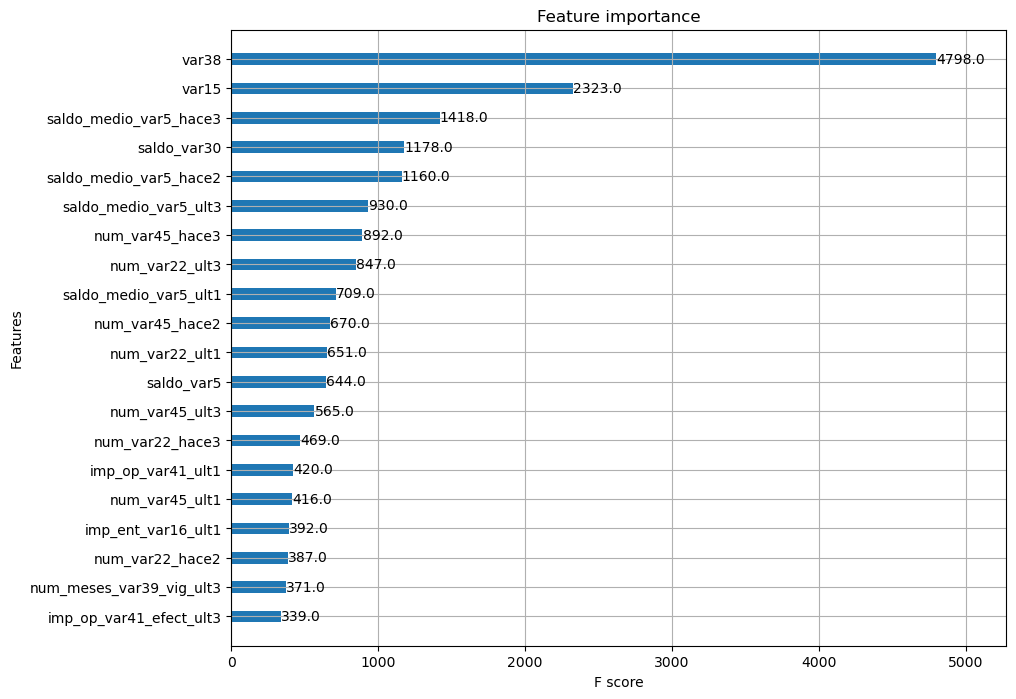

In [39]:
# 튜닝된 모델에서 각 피처의 중요도를 PLOT_importance 메서드로 피처 중요도 그래프를 통해 나타내기
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize = (10,8))
plot_importance(xgb_clf, ax=ax, max_num_features = 20, height = 0.4)

#### LightGBM 모델 학습과 하이퍼 파라미터 튜닝
앞선 데이터 세트를 기반으로 LightGBM으로 튜닝 수행

In [44]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators = 500)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, eval_metric = 'auc', eval_set = evals)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], 
                              average = 'macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 2374, number of negative: 58442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14308
[LightGBM] [Info] Number of data points in the train set: 60816, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039036 -> initscore=-3.203459
[LightGBM] [Info] Start training from score -3.203459
ROC AUC : 0.8140


In [49]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators = 200)
params = {
    'num_leaves' : [32,64],
    'max_depth' : [128,160],
    'min_child_samples' : [60, 100],
    'subsample' : [0.8,1]}
# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, eval_metric = 'auc',
          eval_set = [(X_train, y_train), (X_test, y_test)])
print('gridsearchcv 최적 파라미터', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1] , average = 'macro')
print('ROC AUC :{0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1583, number of negative: 38961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12926
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039044 -> initscore=-3.203239
[LightGBM] [Info] Start training from score -3.203239
[LightGBM] [Info] Number of positive: 1583, number of negative: 38961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13095
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 205
[LightGBM] [Info